In [1]:
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import glob
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as T
import segmentation_models_pytorch as smp
from tqdm import tqdm
import cv2
from skimage import feature
import json
import copy
import pandas as pd

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
val = glob.glob('/workspace/jay/DDP/Ocelot/yolo_binary/datasets/cell_detect_33-1/valid/images/*.jpg')
test = glob.glob('/workspace/jay/DDP/Ocelot/yolo_binary/datasets/cell_detect_33-1/test/images/*.jpg')
train = sorted(glob.glob('/workspace/jay/DDP/Ocelot/ocelot2023/images/train/cell/*.jpg'))
val_files = np.unique(np.array([x.split('/')[-1][:3] for x in val]))
test_files = np.unique(np.array([x.split('/')[-1][:3] for x in test]))
train_files = np.unique(np.array([x.split('/')[-1][:3] for x in train]))

In [3]:
device = 'cuda:2'
model = torch.load('/workspace/jay/DDP/Ocelot/cell_seg/deeplab_dice_ckpts/142_0.29378.pt',map_location=device)
model = model.to(device)
softmax = torch.nn.Softmax(dim=1)

In [4]:
pred_json = {
    "type": "Multiple points",
    "num_images": len(train_files),
    "points": [],
    "version": {
        "major": 1,
        "minor": 0,
    }
}

In [5]:
def find_cells(heatmap,min_dist=10):
    """This function detects the cells in the output heatmap
    Parameters
    ----------
    heatmap: torch.tensor
        output heatmap of the model,  shape: [1, 3, 1024, 1024]
    Returns
    -------
        List[tuple]: for each predicted cell we provide the tuple (x, y, cls, score)
    """
    arr = heatmap[0,:,:,:].cpu().detach().numpy()
    # arr = np.transpose(arr, (1, 2, 0)) # CHW -> HWC

    pred_wo_bg,bg = np.split(arr, (2,), axis=0) # Background and non-background channels
    bg = np.squeeze(bg, axis=0)
    obj = 1.0 - bg

    arr = cv2.GaussianBlur(obj, (5,5), sigmaX=3)
    peaks = feature.peak_local_max(
        arr, min_distance=min_dist, exclude_border=0, threshold_abs=0.0
    ) # List[y, x]

    maxval = np.max(pred_wo_bg, axis=0)
    maxcls_0 = np.argmax(pred_wo_bg, axis=0)

    # Filter out peaks if background score dominates
    peaks = np.array([peak for peak in peaks if bg[peak[0], peak[1]] < maxval[peak[0], peak[1]]])
    if len(peaks) == 0:
        return []

    # Get score and class of the peaks
    scores = maxval[peaks[:, 0], peaks[:, 1]]
    peak_class = maxcls_0[peaks[:, 0], peaks[:, 1]]

    predicted_cells = [(x, y, c + 1, float(s)) for [y, x], c, s in zip(peaks, peak_class, scores)]

    return predicted_cells

In [6]:
file = test_files[1]
idx = int(file) -1 
cell_path = f'/workspace/jay/DDP/Ocelot/ocelot2023/images/train/cell/{file}.jpg'
tissue_path = f'/workspace/jay/DDP/Ocelot/ocelot2023/images/train/tissue/{file}.jpg'
annot_path = f'/workspace/jay/DDP/Ocelot/ocelot2023/annotations/train/cell/{file}.csv'
mask = np.moveaxis(np.load(f'/workspace/jay/DDP/Ocelot/ocelot2023/cell_seg_masks/{file}.npy'),0,-1)
cell = np.array(Image.open(cell_path))
cell = cell / 255
cell = cell - 0.5
cell = torch.Tensor(np.moveaxis(cell, -1, 0))
cell = cell[None,:]
cell = cell.to(device)
with torch.no_grad():
    out_mask = softmax(model(cell))
output = np.moveaxis(out_mask[0].cpu().numpy(),0,-1)


                                

Text(0.5, 1.0, 'Predicted mask')

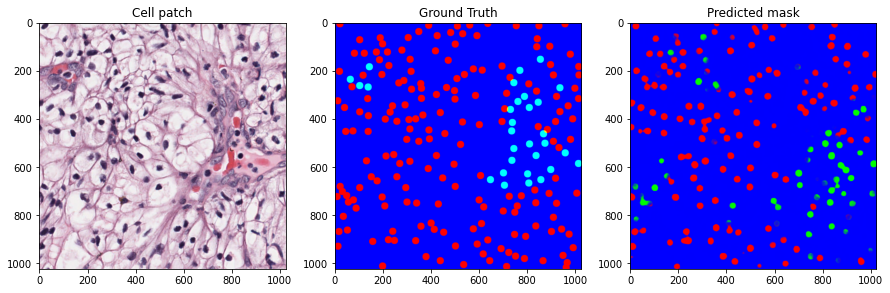

In [8]:
final_out = np.zeros((1024,1024,3))
final_out[:,:,0] = output[:,:,1]
final_out[:,:,1] = output[:,:,0]
final_out[:,:,2] = output[:,:,2]
final_gt = np.zeros((1024,1024,3))
final_gt[:,:,0] = mask[:,:,1]
final_gt[:,:,1] = mask[:,:,0]
final_gt[:,:,2] = mask[:,:,2]

fig, ax = plt.subplots(1,3)
fig.set_figwidth(15)
fig.set_figheight(6)
ax[0].imshow(Image.open(cell_path))
ax[0].set_title('Cell patch')
ax[1].imshow(final_gt)
ax[1].set_title('Ground Truth')
ax[2].imshow(final_out)
ax[2].set_title('Predicted mask')

In [9]:
predicted_cells = find_cells(out_mask,min_dist=10)
img1 = np.array(Image.open(cell_path))
img2 = copy.deepcopy(img1)
df = pd.read_csv(annot_path,header=None)

In [10]:
for i in range(len(df)):
    x,y = df.loc[i][0],df.loc[i][1]
    clas = df.loc[i][2] - 1
    start = (x-17,y-17)
    end = (x+17,y+17)
    if clas==0:
        cv2.rectangle(img1, start, end, (0,255,0),2)     # class = 0, BC, Green
    else:
        cv2.rectangle(img1, start, end, (255,0,0),2)     # class = 1, TC, Red

In [11]:
for i in range(len(predicted_cells)):
    x,y,clas,prob = predicted_cells[i]
    start = (x-17,y-17)
    end = (x+17,y+17) 
    if clas==1:
        cv2.rectangle(img2, start, end, (0,255,0),2)    # class = 0, BC, Green
    else:
        cv2.rectangle(img2, start, end, (255,0,0),2)    # class = 1, TC, Red

final_img = np.concatenate([img1,np.zeros((1024,50,3)).astype(int)],axis=1)
finall_img = np.concatenate([final_img,img2],axis=1)

In [12]:
plt.ioff()
f = plt.figure()
f.set_figwidth(18)
f.set_figheight(9)
plt.imshow(finall_img)
plt.title('Val: '+file)
f.savefig(f'/workspace/jay/DDP/Ocelot/cell_seg/{file}.png')
plt.close(f)

In [9]:
predicted_cells

[(486, 129, 1, 1.0),
 (313, 127, 1, 1.0),
 (92, 281, 1, 1.0),
 (496, 126, 1, 1.0),
 (93, 271, 1, 1.0),
 (11, 770, 1, 1.0),
 (377, 991, 1, 1.0),
 (552, 26, 1, 1.0),
 (527, 815, 1, 0.9999998807907104),
 (307, 396, 1, 0.9999998807907104),
 (84, 735, 1, 0.9999998807907104),
 (141, 778, 1, 0.9999998807907104),
 (275, 915, 1, 0.9999998807907104),
 (988, 491, 1, 0.9999997615814209),
 (379, 546, 1, 0.9999997615814209),
 (428, 893, 1, 0.9999996423721313),
 (425, 776, 1, 0.9999997615814209),
 (336, 765, 1, 0.9999996423721313),
 (663, 166, 1, 0.9999996423721313),
 (324, 463, 1, 0.9999995231628418),
 (943, 504, 1, 0.9999995231628418),
 (914, 243, 2, 0.9999992847442627),
 (406, 652, 1, 0.9999991655349731),
 (590, 22, 1, 0.9999995231628418),
 (526, 947, 1, 0.9999992847442627),
 (111, 922, 1, 0.9999991655349731),
 (167, 467, 1, 0.9999988079071045),
 (1010, 99, 2, 0.999998927116394),
 (498, 820, 1, 0.9999988079071045),
 (379, 863, 1, 0.9999985694885254),
 (336, 849, 1, 0.9999983310699463),
 (227, 431,